### Importing the dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import plotly.express as px

# For dealing with textual data
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [2]:
# Loading the data from csv file
df = pd.read_csv('../Dataset/glassdoor_jobs.csv')

### Exploratory data analysis

In [3]:
df.sample(3)

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
253,253,Data Scientist - Quantitative,$86K-$139K (Glassdoor est.),Truckstop.com is hiring a Data Scientist for o...,3.8,Truckstop.com\n3.8,"Chicago, IL","New Plymouth, ID",501 to 1000 employees,1995,Company - Private,Logistics & Supply Chain,Transportation & Logistics,Unknown / Non-Applicable,-1
786,786,Medical Lab Scientist - MLT,$21-$29 Per Hour(Glassdoor est.),Position Type: Regular\nScheduled Hours per 2 ...,3.2,Catholic Health Initiatives\n3.2,"Omaha, NE","Englewood, CO",10000+ employees,1996,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$10+ billion (USD),"Dignity Health, Trinity Health"
705,705,"Principal, Data Science - Advanced Analytics",$86K-$137K (Glassdoor est.),IQVIA is the leading human data science compan...,3.6,IQVIA\n3.6,"Plymouth Meeting, PA","Durham, NC",10000+ employees,2017,Company - Public,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,$2 to $5 billion (USD),"PPD, INC Research, PRA Health Sciences"


Let's write the things which I think needs to be done from the very first glance of the dataset
- Extract the salary numerical values and create new feature with average salary value
- Extract the company name from given format of {company/rating}
- Remocal of unnecessary features such Unnamed 0,Competitors,Headquarters,Rating -> Because rating is done on what basis

In [4]:
# Removing the unnecessary feature
df.drop(['Unnamed: 0','Competitors','Headquarters','Rating'],axis=1,inplace=True)

In [5]:
# Storing the indexes of the rows having per hour amount mentioned
indices = []
for index, row in df.iterrows():
    if 'Per Hour' in row['Salary Estimate']:  
        indices.append(index)

# Removing the rows 
df = df.drop(indices)
df.reset_index(drop=True,inplace=True)

In [6]:
diff_format_indices = []
for idx,row in df.iterrows():
    if 'Provided' in row['Salary Estimate']:
        diff_format_indices.append(idx)

set_diff_format_indices = set(diff_format_indices)

In [7]:
avg_salary = []

for index, row in df.iterrows():
    salary_data_yearly = row['Salary Estimate']
    
    if salary_data_yearly != str(-1):

        if index not in set_diff_format_indices:
            lower_raw, upper_raw = salary_data_yearly.split('(')[0].split('-')
            lower_value, upper_value = np.int64(lower_raw[1:-1]), np.int64(upper_raw[1:-2])
            avg_salary.append(np.mean([lower_value, upper_value]))  
        else:

            # Using different extraction for the per hour instances
            lower_raw, upper_raw = salary_data_yearly.split(':')[1].split('-')
            lower_value, upper_value = np.int64(lower_raw[1:-1]), np.int64(upper_raw[1:-1])
            avg_salary.append(np.mean([lower_value, upper_value]))  
    else:
        avg_salary.append(-1)

# Adding a new feature
df['Avg_salary'] = avg_salary
df.drop(['Salary Estimate'],axis=1,inplace=True)

#### Cleaning the compnay name feature

In [8]:
company_name = []

for index, row in df.iterrows():
    item = row['Company Name'].split('\n')[0]
    company_name.append(item) 

df['company_name'] = company_name
df.drop(['Company Name'],axis=1,inplace=True)

#### Cleaning the job description feature

In [9]:
def process_jd(text):
    """
    Clean and preprocess a job description text.

    Parameters:
        text (str): The job description text to be processed.

    Returns:
        str: The cleaned and preprocessed job description text.

    Steps:
        1. Replaces newline characters ('\n') with spaces.
        2. Converts the text to lowercase.
        3. Removes punctuation.
        4. Removes English stop words.
        5. Lemmatizes the remaining words.
    """
    # Replacing \n with ' '
    text = text.replace('\n', ' ')
    
    # Lowercasing
    text_lower = text.lower()
    
    # Removing punctuation
    text_no_punctuation = text_lower.translate(str.maketrans('', '', string.punctuation))
    
    # Removing stop words
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text_no_punctuation)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    
    # Lemmatization
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
    
    clean_text = ' '.join(lemmatized_text)    
    return clean_text

In [ ]:
# Creating new feature for the clean job description and also removing the old feature
df['jd'] = df['Job Description'].map(process_jd)
df.drop(['Job Description'],axis=1,inplace=True)

#### Extracting the age of company

In [ ]:
# Replacing the year founded with age of company and keeping -1 as they are
for i in range(len(df)):
    item = df.at[i, 'Founded']
    if item != -1:
        df.at[i, 'Founded'] = 2024 - item

In [ ]:
fig = px.box(df, x='Founded')

# Update layout with title and axis labels
fig.update_layout(title='Interactive Boxplot', xaxis_title='Category')

# Show the plot
fig.show()

In [ ]:
fig = px.scatter(df, x='Founded', y='Avg_salary', trendline="ols")

# Update the color of the regression line
fig.update_traces(line=dict(color='red'))

# Update layout with title and axis labels
fig.update_layout(title='Regression Plot', xaxis_title='Founded', yaxis_title='Salary')

# Show the plot
fig.show()

In [ ]:
df.info()

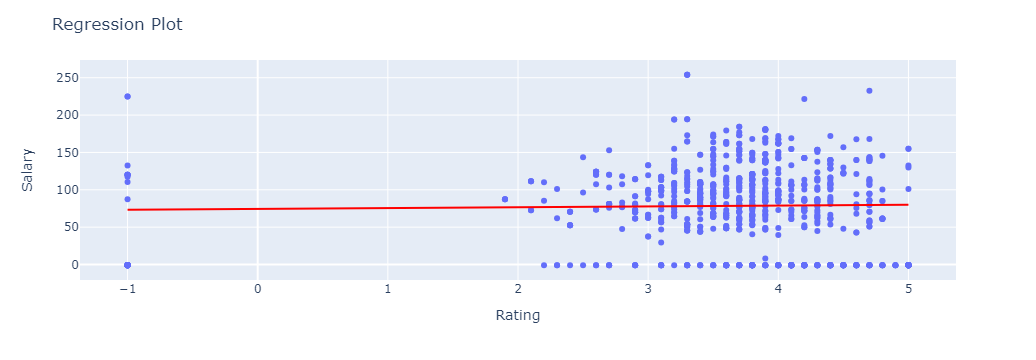

In [32]:
fig = px.scatter(df, x='Rating', y='Avg_salary', trendline="ols")

# Update the color of the regression line
fig.update_traces(line=dict(color='red'))

# Update layout with title and axis labels
fig.update_layout(title='Regression Plot', xaxis_title='Rating', yaxis_title='Salary')

# Show the plot
fig.show()

In [33]:
df['Rating'].value_counts()

Rating
 3.8    74
 3.9    69
 3.7    66
 3.5    53
 4.0    52
 3.6    48
 3.4    46
 4.4    46
 3.3    41
 4.2    41
 4.3    39
 4.7    38
 4.1    37
-1.0    34
 3.2    34
 3.1    30
 5.0    28
 2.9    22
 4.5    19
 4.6    18
 3.0    17
 2.7    15
 4.8    14
 2.6    14
 2.4     8
 2.8     7
 2.1     5
 4.9     4
 2.3     4
 2.2     3
 1.9     3
 2.5     3
Name: count, dtype: int64

In [30]:
df.head(2)

,Job Title,Rating,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,Avg_salary,company_name,jd
0,Data Scientist,3.8,"Albuquerque, NM",501 to 1000 employees,51,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),72.0,Tecolote Research,data scientist location albuquerque nm educati...
1,Healthcare Data Scientist,3.4,"Linthicum, MD",10000+ employees,40,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),87.5,University of Maryland Medical System,general summary healthcare data scientist posi...


<Axes: xlabel='Founded', ylabel='Count'>

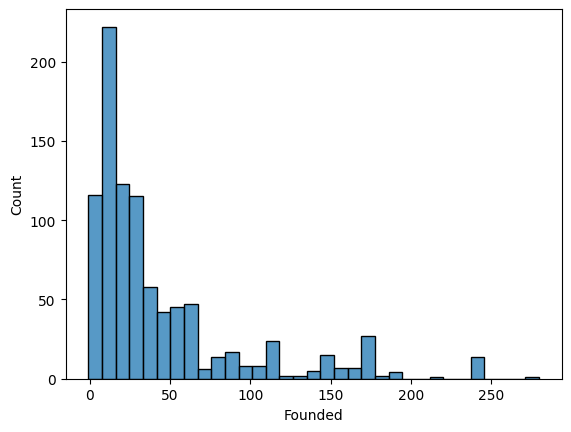

In [16]:
sns.histplot(df['Founded'],bins)

In [17]:
df['Founded'].value_counts()

Founded
-1      97
 16     39
 14     38
 28     36
 11     33
        ..
 79      1
 164     1
 146     1
 82      1
 135     1
Name: count, Length: 108, dtype: int64

In [14]:
type(df.iloc[43]['Founded'])

numpy.int64

In [12]:
df[df['Founded']<100]

,Job Title,Rating,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,Avg_salary,company_name,jd
43,Data Engineer,3.6,"Marlborough, MA",1 to 50 employees,-1,Company - Private,-1,-1,Less than $1 million (USD),98.5,Persivia,position title data engineer persivia seeking ...
48,Data Scientist,5.0,"Washington, DC",Unknown,-1,Company - Private,Enterprise Software & Network Solutions,Information Technology,Unknown / Non-Applicable,155.0,BPA Services,bpa service llc seeking computerdata scientist...
76,Data Scientist,3.2,"Philadelphia, PA",1 to 50 employees,-1,Company - Private,Staffing & Outsourcing,Business Services,$5 to $10 million (USD),128.5,"Numeric, LLC",summaryprovide data management statistical ana...
114,Data Scientist,-1.0,"Gainesville, FL",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable,-1.0,Bridgerock Data,company description founded silicon valley sca...
121,Postdoc Scientist - T cell engineering,-1.0,"Rochester, MN",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable,-1.0,LEAH Labs,postdoctoral scientist – cart cell engineering...
...,...,...,...,...,...,...,...,...,...,...,...,...
881,Scientist - Analytical Development - Pharmaceu...,2.3,"Bristol, TN",51 to 200 employees,-1,Contract,-1,-1,Unknown / Non-Applicable,-1.0,UPM Pharmaceutical Inc,analytical development scientist pharmaceutic ...
900,Data Engineer 5 - Contract,4.2,"Riverton, UT",10000+ employees,-1,Nonprofit Organization,Religious Organizations,Non-Profit,Unknown / Non-Applicable,-1.0,The Church of Jesus Christ of Latter-day Saints,purpose contract position work multiple depart...
901,Data Scientist,3.2,"Philadelphia, PA",1 to 50 employees,-1,Company - Private,Staffing & Outsourcing,Business Services,$5 to $10 million (USD),128.5,"Numeric, LLC",summaryprovide data management statistical ana...
919,"Research Scientist, Immunology - Cancer Biology",-1.0,"Cambridge, MA",Unknown,-1,Company - Private,-1,-1,Unknown / Non-Applicable,120.0,Kronos Bio,research scientist immunology cancer biology l...


In [18]:
df['Founded'].value_counts()

Founded
2025    97
16      39
14      38
28      36
11      33
        ..
79       1
164      1
146      1
82       1
135      1
Name: count, Length: 108, dtype: int64

In [10]:
df['Salary Estimate'].value_counts()

Salary Estimate
-1                                  214
$86K-$143K (Glassdoor est.)           6
$54K-$115K (Glassdoor est.)           6
$49K-$113K (Glassdoor est.)           6
$21-$34 Per Hour(Glassdoor est.)      6
                                   ... 
$74K-$119K (Glassdoor est.)           1
$55K-$97K (Glassdoor est.)            1
$15K-$16K(Employer est.)              1
$61K-$106K (Glassdoor est.)           1
$62K-$113K (Glassdoor est.)           1
Name: count, Length: 417, dtype: int64

In [19]:
df.sample(3)

,Job Title,Rating,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,Avg_salary,company_name,jd
137,Senior Data Engineer,3.2,"Charlotte, NC",1001 to 5000 employees,24,Company - Private,Advertising & Marketing,Business Services,$1 to $2 billion (USD),134.0,Red Ventures,mission data team red venture make data easyto...
650,Senior Data Scientist - R&D Oncology,3.9,"New York, NY",10000+ employees,111,Company - Public,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,$10+ billion (USD),137.0,AstraZeneca,astrazenecawe work together deliver innovative...
835,R&D Specialist/ Food Scientist,2.4,"Hoopeston, IL",501 to 1000 employees,2025,Company - Private,Food & Beverage Manufacturing,Manufacturing,$100 to $500 million (USD),52.5,Teasdale Latin Foods,responsibility include may limited performing ...
